# Digital homo- and heterodyne detection

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from qutip import *
import time
from mpl_toolkits.mplot3d import Axes3D

/home/ingrid/.local/lib/python3.10/site-packages/qutip/visualization.py:1192: UserWarning: Deprecated: Use plot_wigner_fock_distribution
  warnings.warn("Deprecated: Use plot_wigner_fock_distribution")


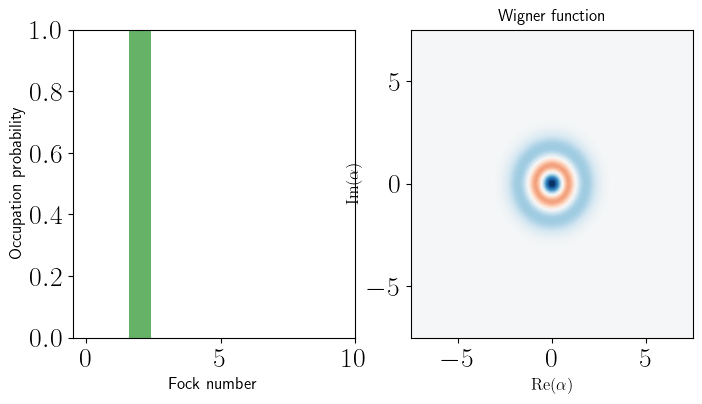

In [2]:
N=10

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
adga = a.dag() * a
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())


N_cav = tensor(num(N), ida)

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*0.5)

initial_cavity = fock(N,2) 

psi0 = tensor(initial_cavity, basis(2,0))
wigner_fock_distribution(initial_cavity);


alpharef = np.sqrt(expect(N_cav, psi0))
n_init = expect(N_cav, psi0)

In [3]:
def dispop(alpha):
    op = alpha * a.dag() - np.conj(alpha) * a
    return op.expm()

def interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

## Qubit-dyne params

In [4]:
## Here are a few options that I tested; see how custom weights are defined below

Nmeas = 140
gint = 0.18
expspeed=0

Nmeas = 40
gint = 0.24
expspeed=1

Nmeas = 35
gint = 0.18
expspeed=2.4

dt=1

In [5]:
Nmeas = 80
gint = 0.25
expspeed=0.8

gamma = gint**2

nsteps = np.linspace(0,Nmeas-1,Nmeas)
tlist = nsteps*dt

angmult=np.exp(expspeed*(nsteps))

angmult = 2/(1 + np.exp(-expspeed*(nsteps)))

#angmult = np.ones_like(nsteps) # constant coupling



def func1(i):
    return 1#(i/5)

angmult = np.array([func1(i) for i in range(Nmeas)])


U_ints=[]
for i in range(Nmeas):
    U_ints.append(interact(gint*angmult[i]*dt))
    #U_ints.append(interact(gint*(1+i/5))) # works fine   
    

## Run simulation to extract weights

In [6]:
# Select quadrature
rotangl = np.pi
qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

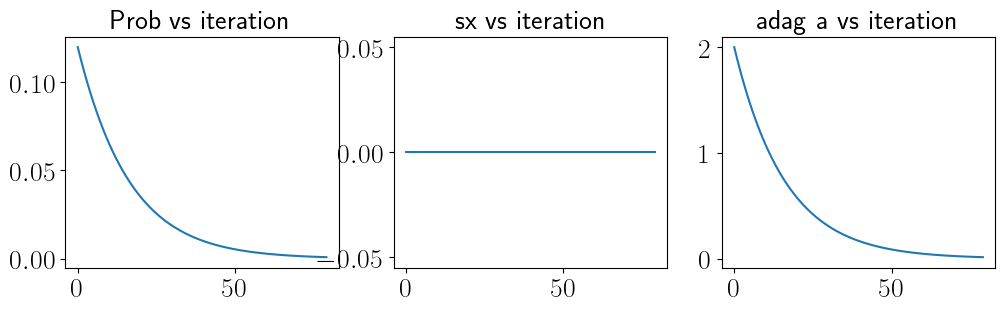

In [7]:
# Find weights by solving unconditional ME

p1exp = []
n_cav = []
sxexp = []
rho = ket2dm(psi0)

expect_a = []

for i in range(Nmeas):
    
    n_cav.append(expect(N_cav, rho))
    U_int = U_ints[i]
    rho = U_int * rho * U_int.dag()
    
    p1val= expect(proj1, rho)
    p1exp.append(p1val)
    
    sxval = expect(sy, rho)
    sxexp.append(sxval)
    
    expect_a.append(expect(a,rho))
    
    rho = tensor(rho.ptrace(0),basis(2,0).proj())
    
## Define weights based on how much pop is extracted from cavity at each round
weights=np.sqrt(np.array(p1exp)/(2*n_init))
#weights = weights/np.sum(weights)

# This correction factor enforces that the measured expectation value of <a> agrees on the reference state
corr = alpharef#/np.sum(sxexp*weights)

fig, axes = plt.subplots(1, 3, figsize=(12,3))

axes[0].plot(p1exp)
# axes[2].plot(0.5-(0.5-np.min(szexp))*np.exp(-np.linspace(0,Nmeas-1,Nmeas)*(gint*gint/2)))
lbl2 = axes[0].set_title("Prob vs iteration")

axes[1].plot(sxexp)
# axes[2].plot(0.5-(0.5-np.min(szexp))*np.exp(-np.linspace(0,Nmeas-1,Nmeas)*(gint*gint/2)))
lbl2 = axes[1].set_title("sx vs iteration")

axes[2].plot(n_cav)
lbl2 = axes[2].set_title("adag a vs iteration")
plt.show()

### plot simulated and calculated qubit excitation probability

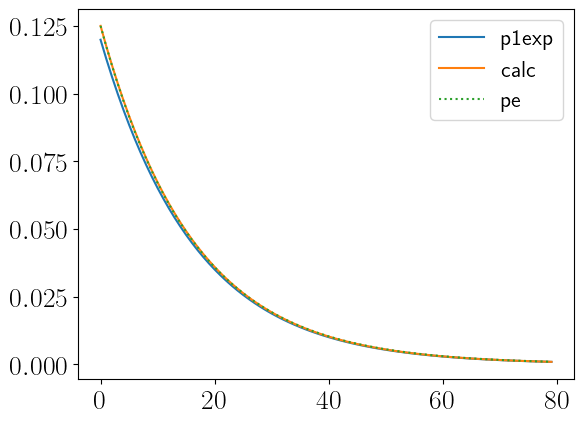

In [8]:
plt.plot(p1exp, label='p1exp')
calc = (gint*angmult*dt)**2*n_cav

plt.plot(calc, label='calc')

pe = gamma*dt*n_init*np.exp(-gamma*dt*nsteps)

plt.plot(pe,':', label='pe')
plt.legend()
filter = np.sqrt(gamma*dt/2)*np.exp(-gamma*dt*nsteps/2)
weights=filter
#plt.plot(0.012*np.cos(angmult*1.32+np.pi/2)**2)

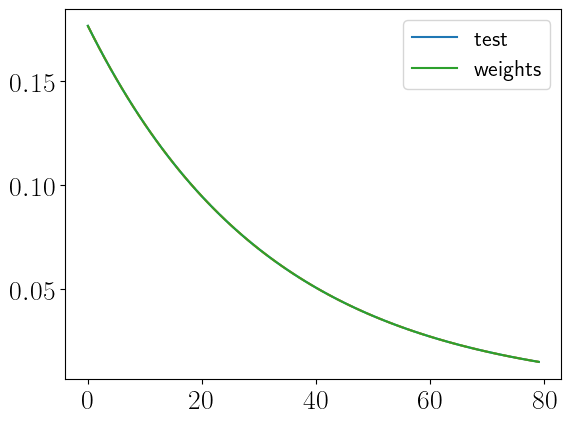

In [9]:
def func_u(step):
    angmult = np.array([func1(i) for i in range(step+1)])
    exponent = np.trapz(angmult, dx=dt)
    return  np.sqrt(func1(step)*gamma*dt/2)*np.exp(-gamma*dt*exponent/2)

test = np.array([func_u(step) for step in range(Nmeas)])
#test /=  np.max(test)#np.trapz(test**2,dx=dt)
#test = alpharef**2*test
plt.plot(test, label='test')
plt.plot(filter,'--')
#angmult = np.array([func1(i) for i in range(20)])
plt.plot(weights, label='weights')
plt.legend();

In [10]:
def test_func(step):
    angmult = np.array([func1(i) for i in range(step+1)])
    exponent = np.trapz(angmult, dx=dt)
    return exponent

test_func(0), test_func(1), test_func(2)

(0.0, 1.0, 2.0)

## compare simulated cavity decay with ME solution

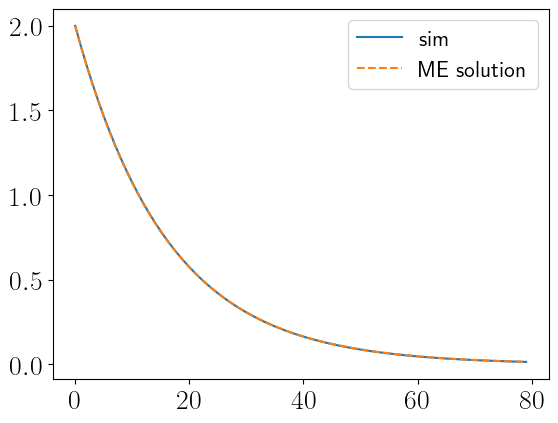

In [11]:

H_int = [(-1j) * gint*np.sqrt(dt)*angle * (a.dag() * sm + a * sm.dag()) for angle in angmult]

c_op=[[a,gint*angmult*np.sqrt(dt)]] # decay rate gamma
opts = Options(nsteps=10000)

sol = mesolve(0*a, psi0, nsteps*dt, c_ops=c_op, e_ops=[N_cav], options=opts)

plt.plot(n_cav, label = 'sim')
plt.plot(nsteps, sol.expect[0], '--',label='ME solution')
#plt.plot(test, ':', label='test')
#plt.plot(alpharef**2 * np.exp(-(tlist*gint)**2/5), label='meh')
#plt.plot(1/(gamma*dt)*pe,':')

plt.legend();

In [12]:
weights_test = np.array(p1exp)
corr_test = alpharef/np.sum(sxexp*weights_test)
#weights_test /= np.sum(weights_test**2)

standard_weights = np.exp(-nsteps*(gint**2))
#standard_weights /= sum(standard_weights**2)
corr_standard = alpharef/np.sum(sxexp*standard_weights)

#plt.plot(weights_test/np.max(weights_test))
#plt.plot(standard_weights)

n_cav[-1], sum(weights_test**2), sum(standard_weights**2), sum(weights**2)

/tmp/ipykernel_3229018/2793787491.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  corr_test = alpharef/np.sum(sxexp*weights_test)
/tmp/ipykernel_3229018/2793787491.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  corr_standard = alpharef/np.sum(sxexp*standard_weights)


(0.01390683777919435,
 0.12445130952691412,
 8.510027582806032,
 0.5123123993001976)

/tmp/ipykernel_3229018/3786597430.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  corr_test = alpharef/np.sum(sxexp*weights_test)
/tmp/ipykernel_3229018/3786597430.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  corr_standard = alpharef/np.sum(sxexp*standard_weights)


1.4142135623730951

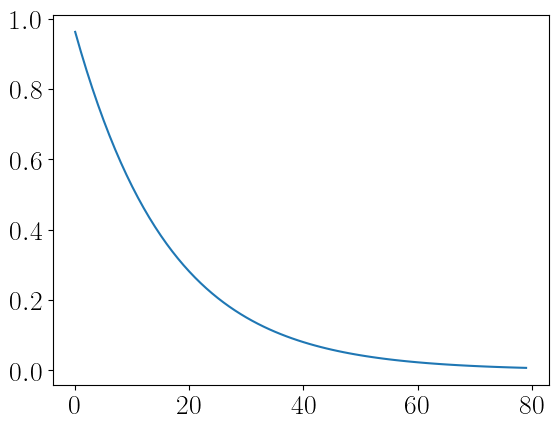

In [13]:
weights_test = np.array(p1exp)
corr_test = alpharef/np.sum(sxexp*weights_test)
weights_test /= np.sum(weights_test**2)

standard_weights = np.exp(-nsteps*(gint**2))
#standard_weights /= sum(standard_weights**2)
corr_standard = alpharef/np.sum(sxexp*standard_weights)

plt.plot(weights_test)
plt.plot(weights_test*corr_test)
#plt.plot(standard_weights)
corr

## Run tomography

In [ ]:
# Repeated homodyne detection: calculate single homodyne shots and collect statistics
# Weights are calculated as above

# Test 
psi0= tensor(basis(N,1), basis(2,0)).unit()

#psi0= tensor(coherent(N,0.5), basis(2,0)).unit()
n_test = expect(N_cav, psi0)

Ntrajs = 1000

quadmeashom = []

xrnd = np.random.rand(Ntrajs*Nmeas)

for j in range(Ntrajs):
    xrnd = np.random.rand(Nmeas)
    
    # xrnd = np.random.rand(Nmeas)
    results = []
    psi = psi0

    for i in range(Nmeas):
        #intmat = interact(gint*angmult[i])
        intmat = U_ints[i]
        psi = qbrotmat * (intmat * psi)

        prob = expect(proj0,psi)
        if prob>xrnd[i]:
            # measured g
            results.append(-1)
            psi = (proj0 * psi).unit()
        else:
            results.append(1)
            # measured e
            psi = (proj1 * psi).unit()
            # go back to g
            psi = qbfeedback * psi
    
    quadmeashom.append(np.sum(results*weights))
    # print('.')


In [ ]:
k=4
plt.hist(np.array(quadmeashom),60,[-k,k],density=True)

x=np.linspace(-k,k,500)
plt.plot(x, np.abs((2/np.sqrt(2))*np.exp(-x**2/2)*(1/np.pi)**(1/4)*x)**2) # 1 photon
#plt.plot(x, np.abs(np.exp(-(x - 1*1.41)**2/2)*(1/np.pi)**(1/4))**2)

# 